In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import scipy.stats

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define paths for the model and data of interest

In [3]:
model_type = "binary"

In [4]:
if model_type == "binary":
    models_base_path = "/users/amtseng/att_priors/models/trained_models/binary/"
else:
    models_base_path = "/users/amtseng/att_priors/models/trained_models/profile/"

In [5]:
condition_name = "BPNet"
noprior_models_path = os.path.join(models_base_path, "BPNet")
prior_models_path = os.path.join(models_base_path, "BPNet_prior")
peak_retention = "all"

### Importing saved metrics JSON files

In [6]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist, or the JSON is
    not well-formed.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    try:
        with open(path, "r") as f:
            return json.load(f)
    except json.JSONDecodeError:
        print("Metrics JSON at %s is not well-formed" % path)

In [7]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func, max_epoch=None):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return True if the _first_ one is better. If `max_epoch` is provided, will only
    report everything up to this epoch (1-indexed).
    Returns the number of the run, the (one-indexed) number of the epoch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                if i == max_epoch:
                    break
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception as e:
            print(e)
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [8]:
def fetch_and_print_performance(models_path, max_epoch=None):
    """
    Given the path to a condition containing many runs, prints out the best validation
    losses for each run. If given, only consider up to `max_epoch` epochs total; anything
    afterward would be ignored.
    """
    if model_type == "binary":
        val_key = "val_corr_losses"
    else:
        val_key = "val_prof_corr_losses"
    
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        val_key,
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %f" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.4f" % (key[0], key[1], all_vals[key]))
    return best_run, best_epoch, all_vals

In [9]:
def plot_test_metric_distributions(noprior_models_path, prior_models_path, noprior_query_run=None, prior_query_run=None):
    if model_type == "binary":
        metric_keys = [
            ("test_acc", "test accuracy", "less"),
            ("test_auroc", "test auROC", "less"),
            ("test_auprc", "test auPRC", "less"),
            ("test_corr_auprc", "estimated test auPRC", "less")
        ]
    else:
        metric_keys = [
            ("summit_prof_nll", "test profile NLL", "greater"),
            ("summit_prof_jsd", "test profile JSD", "greater")
        ]
    
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    noprior_metrics = {run_num : import_metrics_json(noprior_models_path, run_num) for run_num in os.listdir(noprior_models_path)}
    noprior_metrics = {key : val for key, val in noprior_metrics.items() if val}  # Remove empties
    prior_metrics = {run_num : import_metrics_json(prior_models_path, run_num) for run_num in os.listdir(prior_models_path)}
    prior_metrics = {key : val for key, val in prior_metrics.items() if val}  # Remove empties
    
    vals_to_return = []
    
    for metric_key, metric_name, test_alternative in metric_keys:
        noprior_vals = np.array([
            np.mean(metrics[metric_key]["values"]) for metrics in noprior_metrics.values()
        ])
        prior_vals = np.array([
            np.mean(metrics[metric_key]["values"]) for metrics in prior_metrics.values()
        ])
        vals_to_return.append((metric_name, noprior_vals, prior_vals))
        bin_num = 20
        fig, ax = plt.subplots(figsize=(12, 6))
        all_vals = np.concatenate([noprior_vals, prior_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
        ax.hist(noprior_vals, bins=bins, color="coral", label="No prior", alpha=0.7)
        ax.hist(prior_vals, bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
        title = "Histogram of %s without/with Fourier priors" % metric_name
        title += "\n%s, %d/%d %s models" % (condition_name, len(noprior_vals), len(prior_vals), model_type)
        if peak_retention != "all":
            title += "\nTraining on %s peaks" % peak_retention
        ax.set_title(title)
        ax.set_xlabel(metric_name[0].upper() + metric_name[1:])
        plt.legend()
        plt.show()

        u, p = scipy.stats.mannwhitneyu(noprior_vals, prior_vals, alternative=test_alternative)
        print("Mean without priors: %f" % np.mean(noprior_vals))
        print("Mean with priors: %f" % np.mean(prior_vals))
        print("One-sided Mann-Whitney U-test: U = %f, p = %f" % (u, p))
        if noprior_query_run is not None and prior_query_run is not None:
            noprior_mean = np.mean(noprior_metrics[noprior_query_run][metric_key]["values"])
            prior_mean = np.mean(prior_metrics[prior_query_run][metric_key]["values"])
            print("No prior %s (run %s): %f" % (metric_name, noprior_query_run, noprior_mean))
            print("With Fourier prior %s (run %s): %f" % (metric_name, prior_query_run, prior_mean))
    
    return vals_to_return  # List of metric name, noprior values, and prior values

In [10]:
noprior_best_run, noprior_best_epoch, noprior_val_losses = fetch_and_print_performance(noprior_models_path)

Best validation loss overall:
	Best run: 22
	Best epoch in run: 1
	Associated value: 0.348144
Best epoch in each run:
	Run 1, epoch 1: 0.3570
	Run 2, epoch 1: 0.3610
	Run 3, epoch 1: 0.3645
	Run 4, epoch 1: 0.3651
	Run 5, epoch 1: 0.3596
	Run 6, epoch 1: 0.3530
	Run 7, epoch 1: 0.3563
	Run 8, epoch 1: 0.3544
	Run 9, epoch 1: 0.3553
	Run 10, epoch 1: 0.3531
	Run 11, epoch 1: 0.3646
	Run 12, epoch 1: 0.3583
	Run 13, epoch 1: 0.3545
	Run 14, epoch 1: 0.3651
	Run 15, epoch 1: 0.3552
	Run 16, epoch 2: 0.3638
	Run 17, epoch 1: 0.3529
	Run 18, epoch 1: 0.3537
	Run 19, epoch 1: 0.3552
	Run 20, epoch 2: 0.3614
	Run 21, epoch 1: 0.3554
	Run 22, epoch 1: 0.3481
	Run 23, epoch 1: 0.3662
	Run 24, epoch 1: 0.3517
	Run 25, epoch 1: 0.3547
	Run 26, epoch 1: 0.3521
	Run 27, epoch 2: 0.3552
	Run 28, epoch 1: 0.3551
	Run 29, epoch 2: 0.3572
	Run 30, epoch 1: 0.3551


In [11]:
prior_best_run, prior_best_epoch, prior_val_losses = fetch_and_print_performance(prior_models_path)

Best validation loss overall:
	Best run: 27
	Best epoch in run: 11
	Associated value: 0.344159
Best epoch in each run:
	Run 1, epoch 20: 0.3550
	Run 2, epoch 10: 0.3494
	Run 3, epoch 5: 0.3492
	Run 4, epoch 17: 0.3517
	Run 5, epoch 16: 0.3542
	Run 6, epoch 9: 0.3487
	Run 7, epoch 14: 0.3525
	Run 8, epoch 11: 0.3498
	Run 9, epoch 5: 0.3676
	Run 10, epoch 20: 0.3615
	Run 11, epoch 9: 0.3716
	Run 12, epoch 15: 0.3486
	Run 13, epoch 10: 0.3646
	Run 14, epoch 2: 0.3771
	Run 15, epoch 16: 0.3496
	Run 16, epoch 11: 0.3459
	Run 17, epoch 14: 0.3559
	Run 18, epoch 12: 0.3535
	Run 19, epoch 10: 0.3503
	Run 20, epoch 7: 0.3835
	Run 21, epoch 10: 0.3445
	Run 22, epoch 18: 0.3569
	Run 23, epoch 19: 0.3464
	Run 24, epoch 14: 0.3481
	Run 25, epoch 13: 0.3560
	Run 26, epoch 16: 0.3607
	Run 27, epoch 11: 0.3442
	Run 28, epoch 15: 0.3519
	Run 29, epoch 7: 0.3771
	Run 30, epoch 11: 0.3517


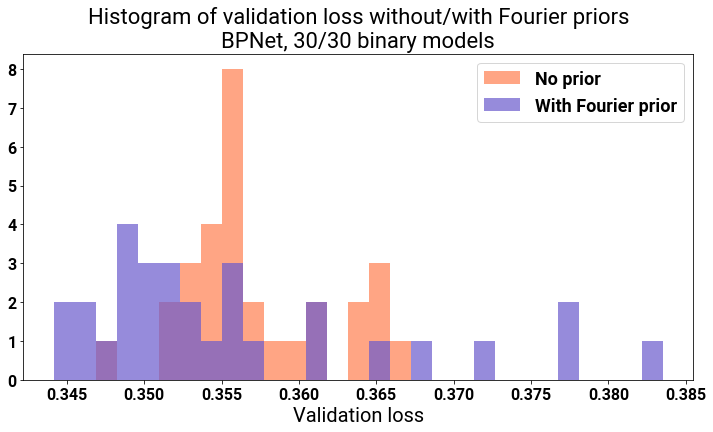

Mean without priors: 0.357163
Mean with priors: 0.355925
One-sided Mann-Whitney U-test: U = 589.000000, p = 0.020298


In [12]:
bin_num = 30
fig, ax = plt.subplots(figsize=(12, 6))
noprior_vals, prior_vals = np.array(list(noprior_val_losses.values())), np.array(list(prior_val_losses.values()))
all_vals = np.concatenate([noprior_vals, prior_vals])
bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
ax.hist(noprior_vals, bins=bins, color="coral", label="No prior", alpha=0.7)
ax.hist(prior_vals, bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
if model_type == "binary":
    title = "Histogram of validation loss without/with Fourier priors"
else:
    title = "Histogram of validation profile NLL loss without/with Fourier priors"
title += "\n%s, %d/%d %s models" % (condition_name, len(noprior_vals), len(prior_vals), model_type)
if peak_retention != "all":
    title += "\nTraining on %s peaks" % peak_retention
ax.set_title(title)
if model_type == "binary":
    ax.set_xlabel("Validation loss")
else:
    ax.set_xlabel("Validation profile NLL loss")
plt.legend()
plt.show()

u, p = scipy.stats.mannwhitneyu(noprior_vals, prior_vals, alternative="greater")
print("Mean without priors: %f" % np.mean(noprior_vals))
print("Mean with priors: %f" % np.mean(prior_vals))
print("One-sided Mann-Whitney U-test: U = %f, p = %f" % (u, p))

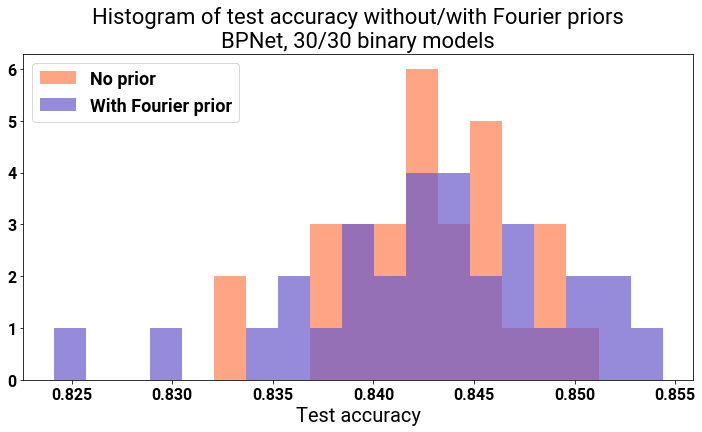

Mean without priors: 0.842561
Mean with priors: 0.842964
One-sided Mann-Whitney U-test: U = 414.000000, p = 0.299845
No prior test accuracy (run 22): 0.846397
With Fourier prior test accuracy (run 27): 0.854374


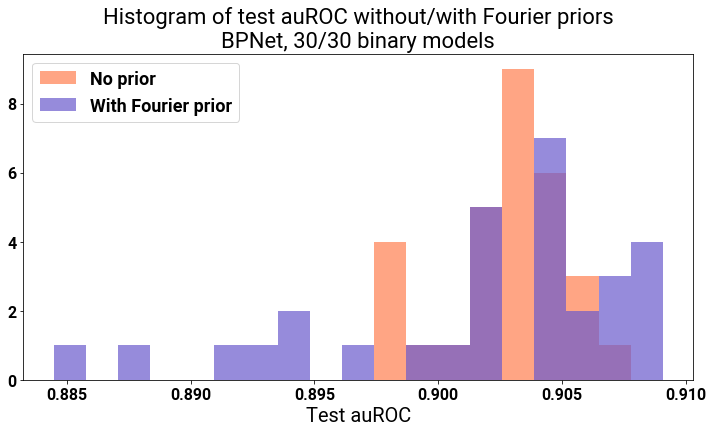

Mean without priors: 0.902740
Mean with priors: 0.901780
One-sided Mann-Whitney U-test: U = 416.000000, p = 0.310202
No prior test auROC (run 22): 0.905759
With Fourier prior test auROC (run 27): 0.908107


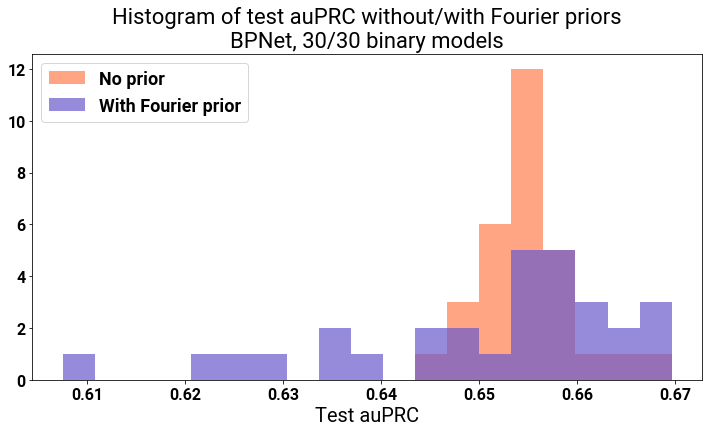

Mean without priors: 0.654693
Mean with priors: 0.650290
One-sided Mann-Whitney U-test: U = 469.000000, p = 0.613440
No prior test auPRC (run 22): 0.655454
With Fourier prior test auPRC (run 27): 0.661023


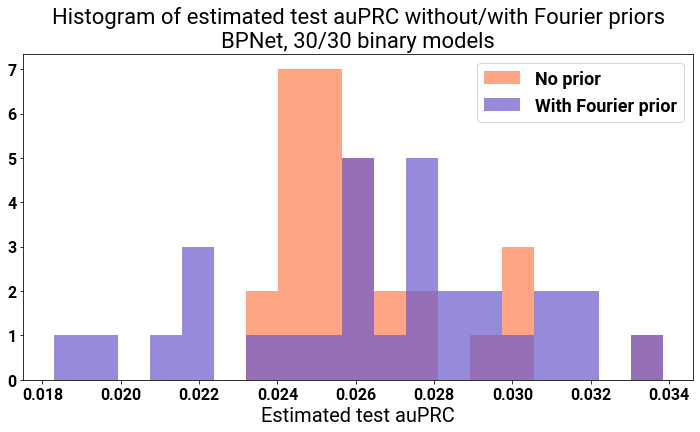

Mean without priors: 0.026286
Mean with priors: 0.026612
One-sided Mann-Whitney U-test: U = 369.000000, p = 0.116994
No prior estimated test auPRC (run 22): 0.024332
With Fourier prior estimated test auPRC (run 27): 0.027793


In [13]:
test_metrics = plot_test_metric_distributions(noprior_models_path, prior_models_path, noprior_best_run, prior_best_run)

Text(0.5, 0.98, 'Model performance without/with Fourier priors\nBPNet, 30/30 binary models')

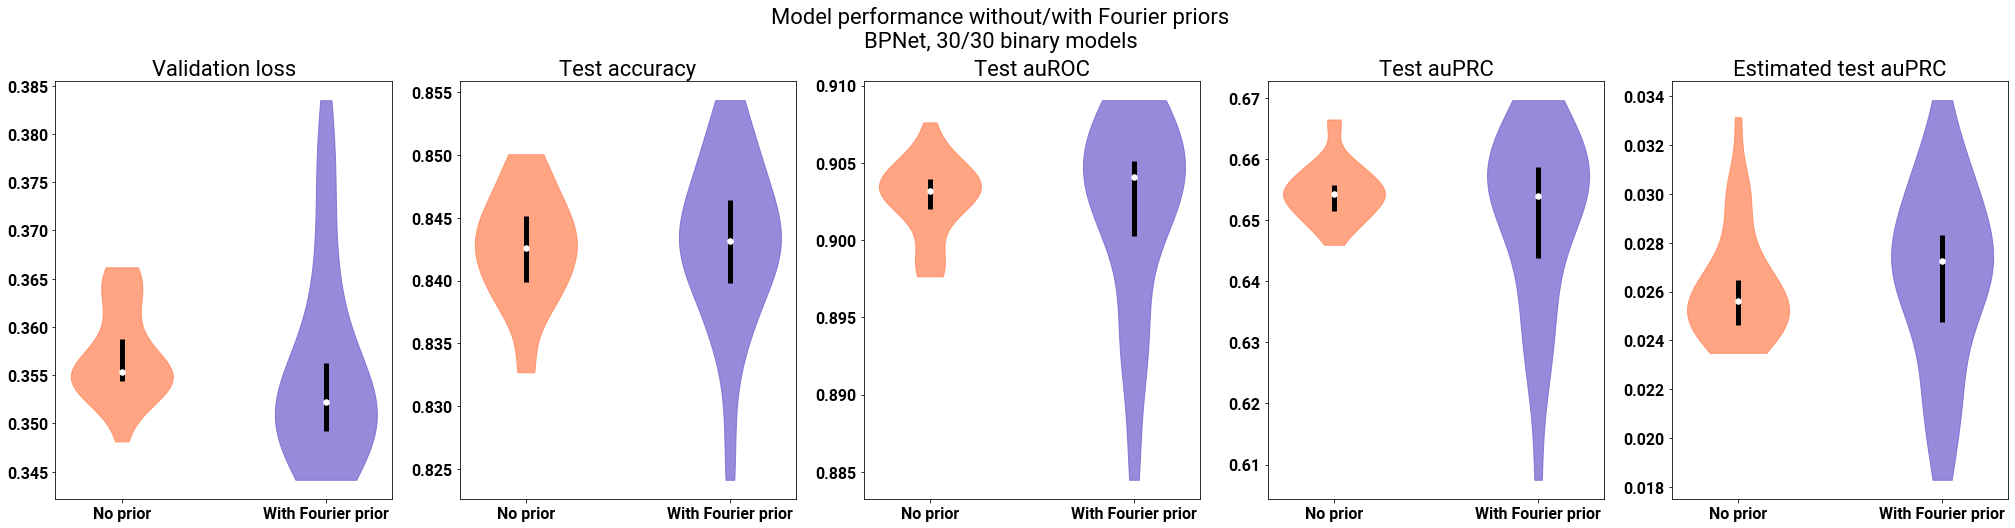

In [14]:
num_violin_plots = 1 + len(test_metrics)
fig, ax = plt.subplots(1, num_violin_plots, figsize=(7 * num_violin_plots, 8))

def create_violin_pair(ax, noprior_data, prior_data, metric_name):
    all_data = np.stack([noprior_data, prior_data], axis=0)
    # Define the quartiles
    q1, med, q3 = np.percentile(all_data, [25, 50, 70], axis=1)
    iqr = q3 - q1
    plot_parts = ax.violinplot(
        [np.sort(all_data[0]), np.sort(all_data[1])], showmeans=False, showmedians=False, showextrema=False
    )
    violin_parts = plot_parts["bodies"]
    violin_parts[0].set_facecolor("coral")
    violin_parts[0].set_edgecolor("coral")
    violin_parts[0].set_alpha(0.7)
    violin_parts[1].set_facecolor("slateblue")
    violin_parts[1].set_edgecolor("slateblue")
    violin_parts[1].set_alpha(0.7)

    inds = np.arange(1, 3)
    ax.vlines(inds, q1, q3, color="black", linewidth=5, zorder=1)
    ax.scatter(inds, med, marker="o", color="white", s=30, zorder=2)
    ax.set_xticks(inds)
    ax.set_xticklabels(["No prior", "With Fourier prior"])
    ax.set_title(metric_name)

create_violin_pair(ax[0], noprior_vals, prior_vals, "Validation profile NLL loss" if model_type == "profile" else "Validation loss")
for i in range(0, len(test_metrics)):
    create_violin_pair(ax[i + 1], test_metrics[i][1], test_metrics[i][2], test_metrics[i][0][0].upper() + test_metrics[i][0][1:])
    
title = "Model performance without/with Fourier priors"
title += "\n%s, %d/%d %s models" % (condition_name, len(noprior_vals), len(prior_vals), model_type)
plt.subplots_adjust(top=0.85)
if peak_retention != "all":
    title += "\nTraining on %s peaks" % peak_retention
    plt.subplots_adjust(top=0.80)
fig.suptitle(title)